In [66]:
import kagglehub
import keras
from keras import layers, regularizers
from keras.callbacks import EarlyStopping
import pandas as pd
from os import path, listdir
import numpy as np

import matplotlib.pyplot as plt

In [2]:

# Download latest version
pathdir = kagglehub.dataset_download("sudipmanchare/simulated-sales-data-with-timeseries-features")

print("Path to dataset files:", pathdir)
listdir(pathdir)[:5]

Path to dataset files: /home/hanibounoua/.cache/kagglehub/datasets/sudipmanchare/simulated-sales-data-with-timeseries-features/versions/2


['sales.csv']

In [3]:
df = pd.read_csv(path.join(pathdir, 'sales.csv'), date_format='%Y-%m-%d', parse_dates = ['Date'])
df.head()

,Unnamed: 0,Date,Sales
0,0,2021-10-01,29.109547
1,1,2021-10-02,30.720435
2,2,2021-10-03,30.305173
3,3,2021-10-04,27.390893
4,4,2021-10-05,22.841123


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  365 non-null    int64         
 1   Date        365 non-null    datetime64[ns]
 2   Sales       365 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.7 KB


In [37]:
ts = (
    df
    .set_index(['Date'])
    .loc[:,['Sales']]
)
ts.head()

,Sales
Date,
2021-10-01,29.109547
2021-10-02,30.720435
2021-10-03,30.305173
2021-10-04,27.390893
2021-10-05,22.841123


In [38]:
def create_ts_series (data, steps):
    
    X, y = list(), list()
    
    for i in range(len(data) - steps):
        X.append(data[i:(i+steps)])
        y.append(data[i+steps])
    
    return np.array(X), np.array(y)

In [39]:
reshape_test = ts.to_numpy()[:,0]
n_steps = 20
X, y = create_ts_series(reshape_test, n_steps) 

In [58]:
n_samples = y.shape[0]
n_samples

345

In [59]:
X_train = X[:250, :].copy()
y_train = y[:250].copy()
X_test = X[250:, :].copy()
y_test = y[250:].copy()

In [60]:
y_test

array([34.67261139, 30.50712906, 38.21041786, 41.38558777, 43.3178696 ,
       42.58548158, 39.29374178, 34.50746111, 31.59903735, 38.66899841,
       41.23495379, 45.3404509 , 42.63438511, 40.68637705, 35.25990873,
       34.58856565, 35.90925219, 42.90663974, 45.36009635, 44.97828118,
       38.87191244, 34.84253793, 36.63363851, 36.24448973, 41.90954475,
       46.15716955, 44.12415992, 40.43295368, 35.27411602, 35.0497777 ,
       36.3479787 , 44.05362513, 45.25211414, 43.69625675, 40.86638308,
       35.56284526, 33.69546334, 36.65778805, 43.4392676 , 45.56070475,
       44.59273339, 41.62774381, 35.24673924, 34.64904406, 37.96962574,
       43.18984604, 46.02810673, 44.78954776, 40.8383736 , 36.61625977,
       35.01011743, 37.89151256, 43.72001081, 45.5293631 , 44.26907969,
       40.93770775, 36.91589803, 38.33644531, 38.34980528, 44.73875517,
       47.51746652, 44.58749   , 42.37325298, 36.23968441, 33.77054958,
       40.01082508, 42.38960386, 47.57121265, 45.44242406, 43.60

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Dt_train = scaler.fit_transform(np.column_stack((X_train, y_train.reshape(-1, 1))))
Dt_test = scaler.transform(np.column_stack((X_test, y_test.reshape(-1, 1))))
X_train, y_train = Dt_train[:, :20], np.squeeze(Dt_train[:, 20]) 
X_test, y_test = Dt_test[:, :20], np.squeeze(Dt_test[:, 20]) 

In [62]:
n_train_samples, n_test_samples, n_steps, n_features = X_train.shape[0], X_test.shape[0], X.shape[1], 1
X_train = X_train.reshape((n_train_samples, n_steps, n_features))
X_test = X_test.reshape((n_test_samples, n_steps, n_features))

In [74]:
lstm_model = keras.Sequential()

lstm_model.add(layers.Input(shape = (n_steps, n_features)))
lstm_model.add(layers.LSTM(units=10, kernel_regularizer=regularizers.l2(0.001)))
lstm_model.add(layers.Dropout(0.2)) 
lstm_model.add(layers.Dense(units=1, activation='relu'))

lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=.001), loss='mae', metrics=['mae'])

lstm_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, batch_size=128, epochs=60, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - loss: 0.8014 - mae: 0.7999 - val_loss: 1.3306 - val_mae: 1.3290
Epoch 2/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.8035 - mae: 0.8020 - val_loss: 1.3011 - val_mae: 1.2995
Epoch 3/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.7959 - mae: 0.7943 - val_loss: 1.2722 - val_mae: 1.2707
Epoch 4/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.7973 - mae: 0.7957 - val_loss: 1.2430 - val_mae: 1.2414
Epoch 5/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.7926 - mae: 0.7910 - val_loss: 1.2144 - val_mae: 1.2129
Epoch 6/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.7927 - mae: 0.7912 - val_loss: 1.1852 - val_mae: 1.1837
Epoch 7/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.7894 - mae: 0.7878 - val_loss: 1.1561 - val_mae: 1.1546
Epoch 8/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.7876 - mae: 0.7860 - val_loss: 1.1258 - val_mae: 1.1243
Epoch 9/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.7880 - mae: 

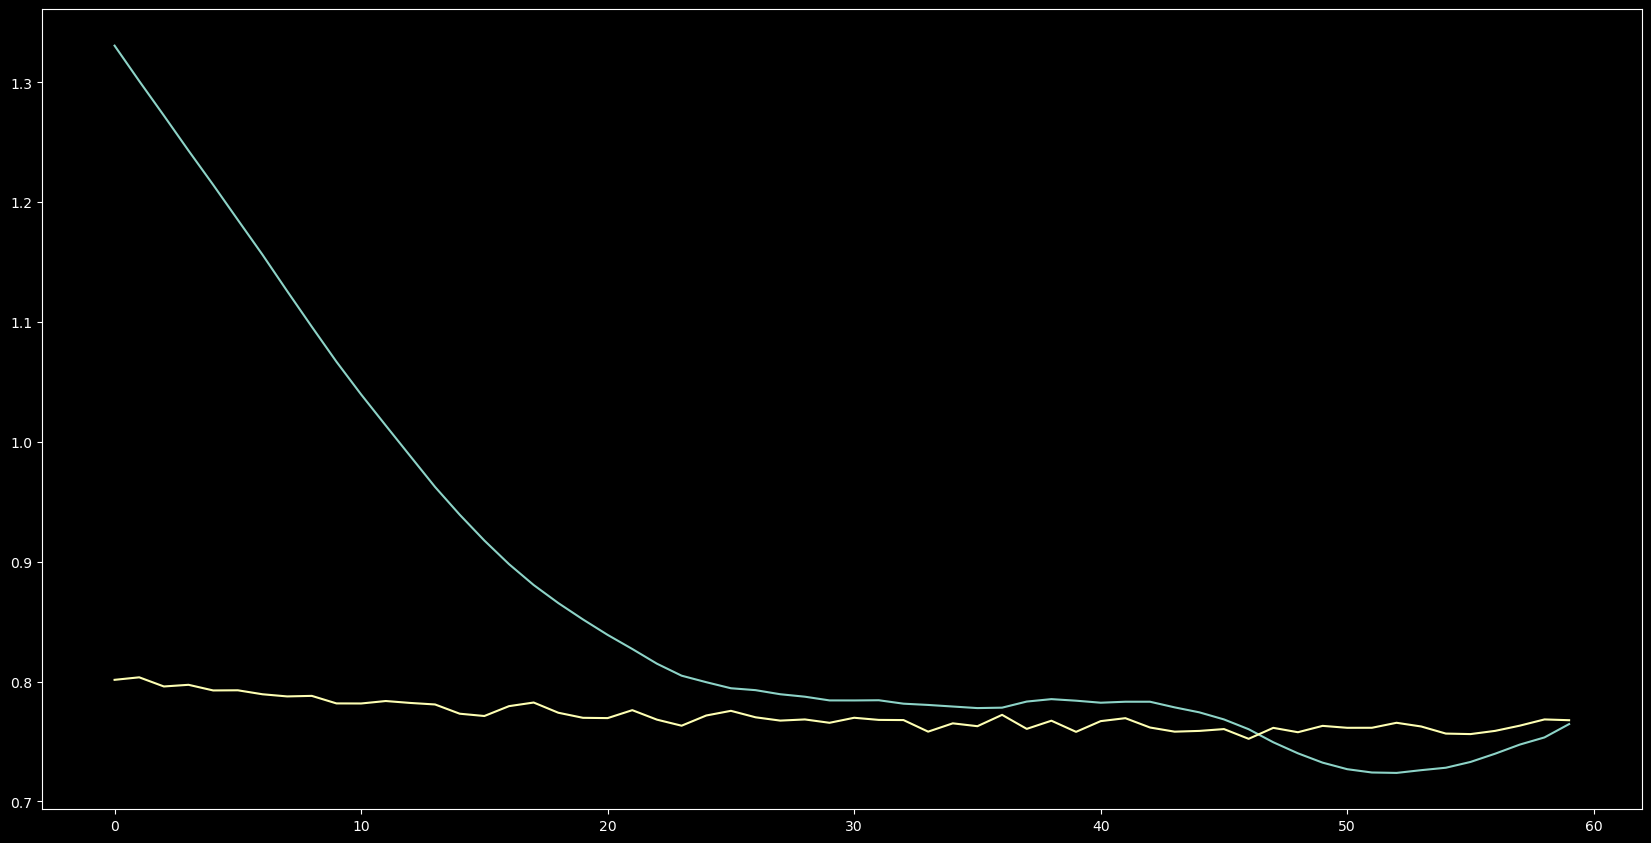

In [76]:
history = lstm_model.history


fig = plt.figure(figsize=(16, 8))

ax = fig.add_axes(rect=(0,0,1,1))

ax.plot(history.history['val_loss'])
ax.plot(history.history['loss'])